In [1]:
from scipy.io import loadmat
import numpy as np

In [2]:
data = loadmat("./datasets/MNISTmini.mat")

train_fea = data['train_fea1']
train_gnd = data['train_gnd1']
test_fea = data['test_fea1']
test_gnd = data['test_gnd1']

#print(np.shape(train_fea)) # (60000, 100)
#print(np.shape(train_gnd)) # (60000, 1)
#print(np.shape(test_fea)) # (10000, 100)
#print(np.shape(test_gnd)) # (10000, 1)

In [3]:
# insert labels as last column of feature matrix
train_samples = np.column_stack((train_fea, train_gnd)) 

#print(train_samples)
#print(train_samples.shape)

In [4]:
from sklearn.utils import resample

# sample (w/o replacement) 3000 samples from train_samples
sub_samples = resample(train_samples, replace=False, n_samples=3000, random_state=20)

# print(np.unique(sub_samples[:,-1])) # 10 total classes: 0-9, so to classify image as digit-0 -> class 1

sub_train_fea = sub_samples[0:1000, :100]
sub_train_gnd = sub_samples[0:1000, 100]

sub_val_fea = sub_samples[1000:2000, :100]
sub_val_gnd = sub_samples[1000:2000, 100]

sub_test_fea = sub_samples[2000:3000, :100]
sub_test_gnd = sub_samples[2000:3000, 100]

# digit-5 samples:
full_sample_digit_5 = sub_samples[2000:3000][sub_samples[2000:3000, -1] == 6] # digit-5 = class 6
test_digit_5_fea = full_sample_digit_5[:50,:100]
test_digit_5_gnd = full_sample_digit_5[:50, 100]

#print("Full test sample matrix containing label for digit-5:\n", full_sample_digit_5)
#print("Test sample features:\n", test_digit_5_fea) # 86/1000 total rows
#print("Test sample labels:\n", test_digit_5_gnd) # 86/1000 rows are labeled as digit 5

# digit-8 samples:
full_sample_digit_8 = sub_samples[2000:3000][sub_samples[2000:3000, -1] == 9] # digit-8 = class 9
test_digit_8_fea = full_sample_digit_8[:50, :100]
test_digit_8_gnd = full_sample_digit_8[:50, 100]

#print("Full sample matrix containing label for digit-8:\n", full_sample_digit_8)
#print("Test sample features:\n", len(test_digit_8_fea)) # 115/1000 total rows 
#print("Test sample labels\n", len(test_digit_8_gnd)) # 115/1000 rows are labeled as digit 8


In [5]:
# Train/Validation/Test Split: 33/33/33 for multi-class classification:

# Training set
X_train = sub_train_fea
y_train = sub_train_gnd

# Validation set
X_val = sub_val_fea
y_val = sub_val_gnd

# Test set
X_test = sub_test_fea
y_test = sub_test_gnd

#print(X_test)
#print(y_test)

# Binary classification (digit-5, digit-8)

# Test set (digit-5/class 6)
X_test_digit_5 = test_digit_5_fea
y_test_digit_5 = test_digit_5_gnd

# Test set (digit-8/class 9)
X_test_digit_8 = test_digit_8_fea
y_test_digit_8 = test_digit_8_gnd


In [6]:
classes, counts = np.unique(y_train, return_counts=True)

# Check class distribution to determine if classes are balanced/imbalanced
print("Class distribution:")
for cls, count in zip(classes, counts):
    print(f'Digit-{cls-1}: {count} samples')

# Proportions for each class
print("\nClass proportions:")
proportions = counts/len(y_train)
for cls, prop in zip(classes, proportions):
    print(f'Digit-{cls-1}: {prop*100:.2f}% of total samples.')

Class distribution:
Digit-0: 106 samples
Digit-1: 102 samples
Digit-2: 107 samples
Digit-3: 101 samples
Digit-4: 87 samples
Digit-5: 95 samples
Digit-6: 96 samples
Digit-7: 101 samples
Digit-8: 105 samples
Digit-9: 100 samples

Class proportions:
Digit-0: 10.60% of total samples.
Digit-1: 10.20% of total samples.
Digit-2: 10.70% of total samples.
Digit-3: 10.10% of total samples.
Digit-4: 8.70% of total samples.
Digit-5: 9.50% of total samples.
Digit-6: 9.60% of total samples.
Digit-7: 10.10% of total samples.
Digit-8: 10.50% of total samples.
Digit-9: 10.00% of total samples.


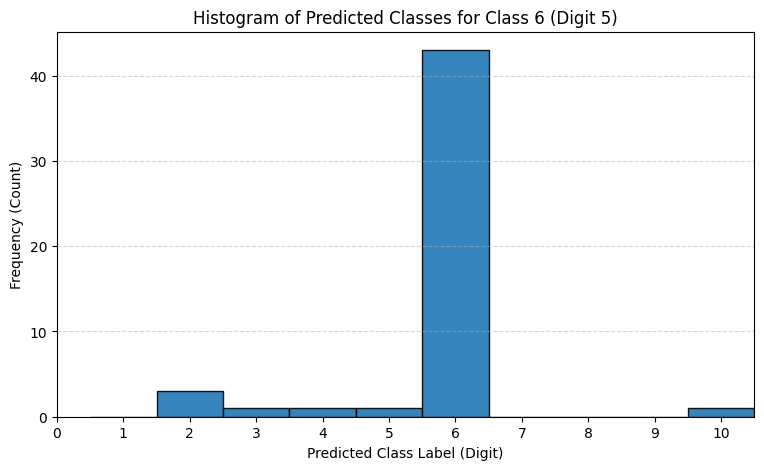

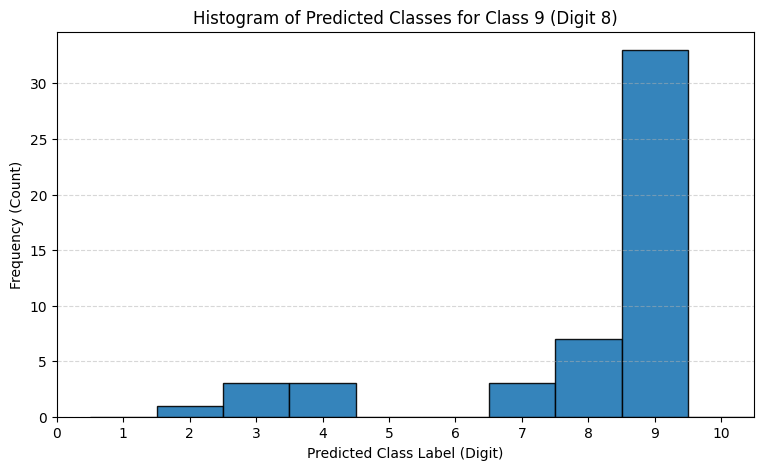

One-vs-rest classifier w/ LR (No cross-validation):
Training time: 0.513s
Inference time: 0.0015s
Predicted class per test sample (digit-5): [ 2  6  6  6  6  6  6  6  6  6  6  6  6  2  6  6  6  6  4  6  6  6  6  6
  6  6  6  3  6  5  6  6  6  6  6  6  6  6 10  6  6  6  6  6  6  6  2  6
  6  6]
Predicted class per test sample (digit-8): [3 9 9 4 9 8 9 3 8 4 9 3 9 9 9 9 9 9 7 9 8 9 9 9 9 9 8 9 9 7 9 4 7 8 9 8 9
 9 9 2 9 9 9 9 9 8 9 9 9 9]
Model prediction accuracy (digit-5): 0.860
Model prediction accuracy (digit-8): 0.660 


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier  
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt

import time

start = time.time()
# One-vs-rest classifier with logistic regression as base estimator
ovr_clf = OneVsRestClassifier(
    LogisticRegression(
        # liblinear implements a trust region newton method
        # n_jobs = 1 (1 core, no parallelism)
        penalty='l2', solver='liblinear', max_iter=1000, random_state=20, verbose=0
    )
    ).fit(X_train, y_train) # train classifier on multi-class training samples (1000 samples)
stop = time.time()

train_time = stop - start

start = time.time()
y_pred_5 = ovr_clf.predict(X_test_digit_5)
y_pred_8 = ovr_clf.predict(X_test_digit_8)
end = time.time()

inference_time = end - start

acc_5 = accuracy_score(y_true=y_test_digit_5, y_pred=y_pred_5)
acc_8 = accuracy_score(y_true=y_test_digit_8, y_pred=y_pred_8)

all_digit_bins = np.arange(0.5, 11.5, 1.0)
unique_classes = np.unique(y_pred_5)

plt.figure(figsize=(9, 5))

# Create the histogram
plt.hist(
    y_pred_5,
    bins=all_digit_bins,
    color='#1f77b4',
    edgecolor='black',
    alpha=0.9
)

plt.title('Histogram of Predicted Classes for Class 6 (Digit 5)')
plt.xlabel('Predicted Class Label (Digit)')
plt.ylabel('Frequency (Count)')

# Force x-ticks to display only the predicted classes
all_digits = np.arange(11)
plt.xticks(all_digits)

# Set dynamic limits for visual padding
min_pred = np.min(y_pred_5)
max_pred = np.max(y_pred_5)
plt.xlim(0, 10.5)


plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()

all_digit_bins = np.arange(0.5, 11.5, 1.0)
unique_classes = np.unique(y_pred_8)

plt.figure(figsize=(9, 5))

# Create the histogram
plt.hist(
    y_pred_8,
    bins=all_digit_bins,
    color='#1f77b4',
    edgecolor='black',
    alpha=0.9
)

plt.title('Histogram of Predicted Classes for Class 9 (Digit 8)')
plt.xlabel('Predicted Class Label (Digit)')
plt.ylabel('Frequency (Count)')

# Force x-ticks to display only the predicted classes
all_digits = np.arange(11)
plt.xticks(all_digits)

# Set dynamic limits for visual padding
min_pred = np.min(y_pred_5)
max_pred = np.max(y_pred_5)
plt.xlim(0, 10.5)


plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()

# Score for digit-5, digit-8 classification w/ one-vs-rest classifier
print("One-vs-rest classifier w/ LR (No cross-validation):")
print(f"Training time: {train_time:.3f}s")
print(f"Inference time: {inference_time:.4f}s")
print(f"Predicted class per test sample (digit-5): {y_pred_5}")
print(f"Predicted class per test sample (digit-8): {y_pred_8}")
print(f"Model prediction accuracy (digit-5): {acc_5:.3f}")
print(f"Model prediction accuracy (digit-8): {acc_8:.3f} ")

In [8]:
start = time.time()
# One-vs-one classifier with logistic regression as base estimator
ovo_clf = OneVsOneClassifier(
        LogisticRegression(
            penalty='l2', solver='liblinear', max_iter=1000, random_state=20, verbose=0
        )
    ).fit(X_train, y_train)
stop = time.time()

train_time = stop - start

start = time.time()
y_pred_5 = ovo_clf.predict(X_test_digit_5) # test classifier on digit-5 samples only from test set (50 samples)
y_pred_8 = ovo_clf.predict(X_test_digit_8) # test classifier on digit-8 samples only from test set (50 samples)
end = time.time()

inference_time = end - start

acc_5 = accuracy_score(y_true=y_test_digit_5, y_pred=y_pred_5)
acc_8 = accuracy_score(y_true=y_test_digit_8, y_pred=y_pred_8)

# Score for digit-5, digit-8 classification w/ one-vs-one classifier
print("One-vs-one classifier w/ LR (No cross-validation):")
print(f"Training time: {train_time:.3f}s")
print(f"Inference time: {inference_time:.4f}s")
print(f"Predicted class per test sample (digit-5 = class 6): {y_pred_5}")
print(f"Predicted class per test sample (digit-8 = class 9): {y_pred_8}")
print(f"Model prediction accuracy (digit-5): {acc_5:.3f}")
print(f"Model prediction accuracy (digit-8): {acc_8:.3f} ")

One-vs-one classifier w/ LR (No cross-validation):
Training time: 0.086s
Inference time: 0.0118s
Predicted class per test sample (digit-5 = class 6): [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6]
Predicted class per test sample (digit-8 = class 9): [3 9 9 4 9 8 9 3 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 4 7 9 9 4 9
 9 9 2 9 9 9 9 9 9 9 9 9 9]
Model prediction accuracy (digit-5): 0.960
Model prediction accuracy (digit-8): 0.820 


In [9]:
from sklearn.linear_model import LogisticRegressionCV

# One-vs-rest logistic regression w/ cross-validation
start = time.time()
clf = OneVsRestClassifier(
    LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='liblinear', max_iter=1000, random_state=20)
).fit(X_train, y_train)
stop = time.time()

train_time = stop - start

start = time.time()
y_pred_5 = clf.predict(X_test_digit_5)
y_pred_8 = clf.predict(X_test_digit_8)
end = time.time()

inference_time = end - start

acc_5 = accuracy_score(y_true=y_test_digit_5, y_pred=y_pred_5)
acc_8 = accuracy_score(y_true=y_test_digit_8, y_pred=y_pred_8)

print("One-vs-rest w/ LR w/ cross-validation:")
print(f"Training time: {train_time:.3f}s")
print(f"Inference time: {inference_time:.4f}s")
print(f"Predicted class per test sample (digit-5 = class 6): {y_pred_5}")
print(f"Predicted class per test sample (digit-8 = class 9): {y_pred_8}")
print(f"Model prediction accuracy (digit-5): {acc_5:.3f}")
print(f"Model prediction accuracy (digit-8): {acc_8:.3f} ")

One-vs-rest w/ LR w/ cross-validation:
Training time: 22.184s
Inference time: 0.0015s
Predicted class per test sample (digit-5 = class 6): [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6]
Predicted class per test sample (digit-8 = class 9): [3 9 9 9 9 1 9 3 4 9 9 1 9 9 9 9 9 9 7 9 9 9 9 9 9 9 7 9 9 7 9 4 7 9 9 4 9
 9 9 2 9 9 9 9 9 5 9 9 9 9]
Model prediction accuracy (digit-5): 0.960
Model prediction accuracy (digit-8): 0.740 


In [10]:
# One-vs-one logistic regression w/ cross-validation
start = time.time()
clf = OneVsOneClassifier(
    LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='liblinear', max_iter=1000, random_state=20)
).fit(X_train, y_train)
stop = time.time()

train_time = stop - start

start = time.time()
y_pred_5 = clf.predict(X_test_digit_5)
y_pred_8 = clf.predict(X_test_digit_8)
end = time.time()

inference_time = end - start

acc_5 = accuracy_score(y_true=y_test_digit_5, y_pred=y_pred_5)
acc_8 = accuracy_score(y_true=y_test_digit_8, y_pred=y_pred_8)

print("One-vs-one w/ LR (w/ cross-validation):")
print(f"Training time: {train_time:.3f}s")
print(f"Inference time: {inference_time:.4f}s")
print(f"Predicted class per test sample (digit-5 = class 6): {y_pred_5}")
print(f"Predicted class per test sample (digit-8 = class 9): {y_pred_8}")
print(f"Model prediction accuracy (digit-5): {acc_5:.3f}")
print(f"Model prediction accuracy (digit-8): {acc_8:.3f} ")

One-vs-one w/ LR (w/ cross-validation):
Training time: 2.933s
Inference time: 0.0117s
Predicted class per test sample (digit-5 = class 6): [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6]
Predicted class per test sample (digit-8 = class 9): [3 9 9 9 9 8 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 9 9 4 9
 9 9 2 9 9 9 9 9 9 9 9 9 9]
Model prediction accuracy (digit-5): 0.960
Model prediction accuracy (digit-8): 0.860 


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(20)
param_dist = {
    'n_estimators': np.random.randint(100, 1001, 100)
}

rf_clf = RandomForestClassifier(random_state=20)

start = time.time()
random_search = RandomizedSearchCV(
    estimator=rf_clf, param_distributions=param_dist, cv=5, scoring='accuracy', random_state=20, n_jobs=-1
).fit(X_train, y_train)
end = time.time()

train_time = end - start

best_model = random_search.best_estimator_

start = time.time()
rf_acc_5 = best_model.score(X_test_digit_5, y_test_digit_5)
rf_acc_8 = best_model.score(X_test_digit_8, y_test_digit_8)
end = time.time()

inference_time = end - start

# Score for digit-5, digit-8 classification over test set random forest classifier
print("Random Forest Classifier (w/ cross-validation to determine # of trees)")
print(f"Training time: {train_time:.3f}s")
print(f"Best score: {random_search.best_score_:.3f}")
print(f"Best parameters: {random_search.best_params_}")
print(f"Inference time: {inference_time:.4f}s")
#print(f"Predicted class per test sample (digit-5 = class 6): {rf_y_pred_5}")
#print(f"Predicted class per test sample (digit-8 = class 9): {rf_y_pred_8}")
print(f"Model prediction accuracy (digit-5): {rf_acc_5:.3f}")
print(f"Model prediction accuracy (digit-8): {rf_acc_8:.3f} ")

Random Forest Classifier (w/ cross-validation to determine # of trees)
Training time: 76.357s
Best score: 0.880
Best parameters: {'n_estimators': np.int32(634)}
Inference time: 0.0515s
Model prediction accuracy (digit-5): 0.980
Model prediction accuracy (digit-8): 0.840 


In [12]:
# Explore parallelized training/testing